## Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [2]:
WaterDelta = pd.read_pickle('.\DataFrames\ProfileWaterDelta.pkl')

In [3]:
GPs = GH.SetGraphicsPatterns(WaterDelta.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = WaterDelta.index.min()
End = WaterDelta.index.max()

Irrigation
['Excess', 'Normal']
Nitrogen
['125', '320', '80']
Treatments
MultiIndex(levels=[['Excess', 'Normal'], ['125', '320', '80']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
           Lin     Col   Alp Mar     MFC
Excess 125   -  orange  0.15   o  orange
       320   -   green  0.15   o   green
       80    -  purple  0.15   o  purple
Normal 125  --  orange  0.45   ^   white
       320  --   green  0.45   ^   white
       80   --  purple  0.45   ^   white


## investigate how much upward flux we are getting at night

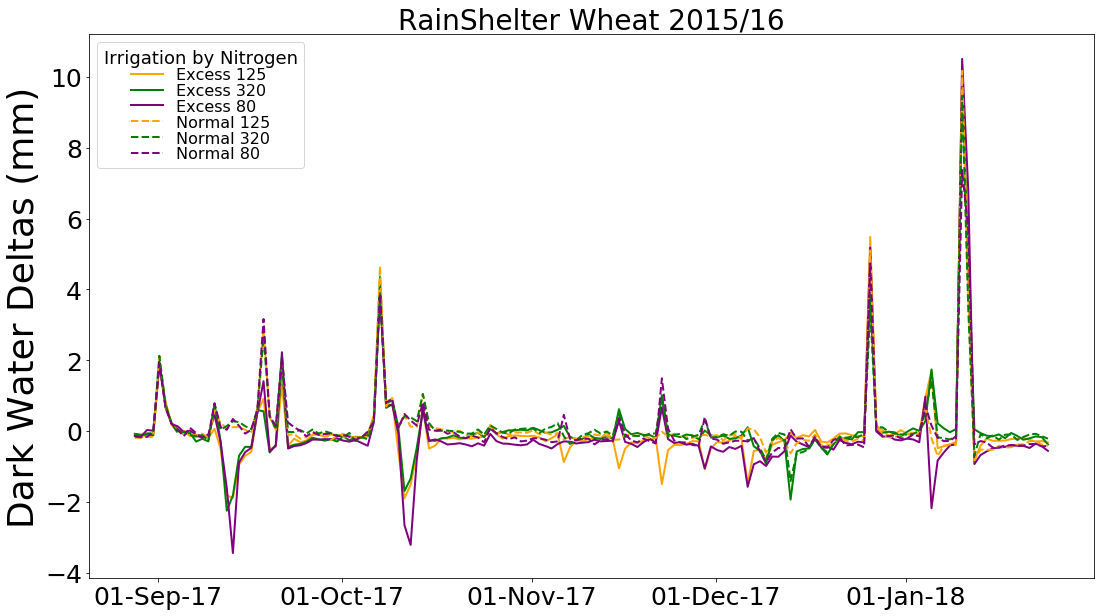

In [4]:
DarkWaterDeltas = WaterDelta.iloc[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(4))]
DarkWaterDeltas = DarkWaterDeltas.resample('24H', base=5).sum()#Base of 5 means sampling from 6am to 6am
MeanDarkWaterDeltas = DarkWaterDeltas.groupby(level=['Irrigation','Nitrogen'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanDarkWaterDeltas,ax,GPs,2)
plt.ylabel('Dark Water Deltas (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Wheat 2015/16', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
GH.AddLegend(2,16,'Irrigation by Nitrogen')

## No strong evidence of upward flux for this experiment

## Work out Irrigation timings and amounts.

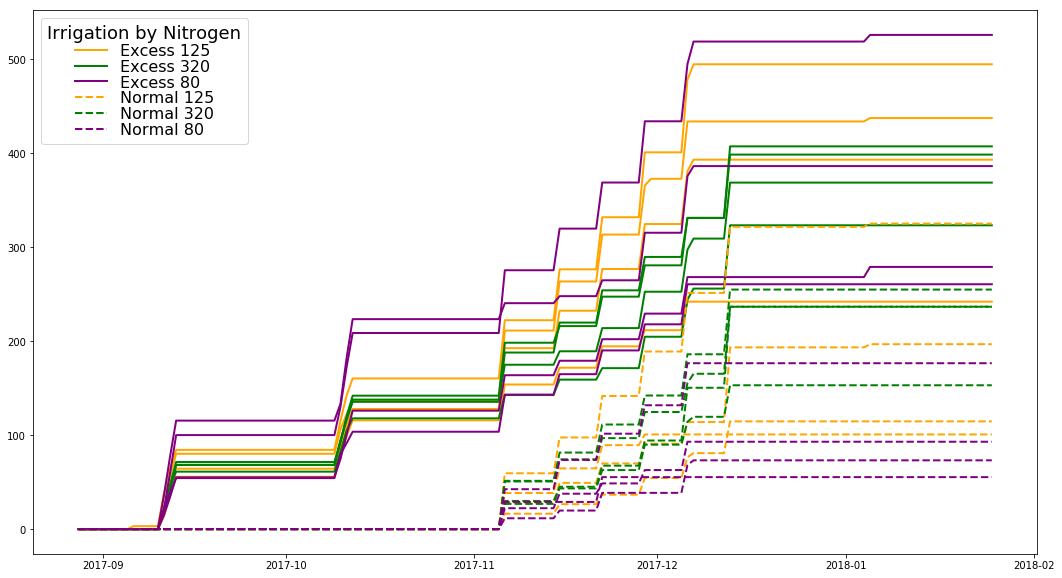

In [5]:
Irrigation = WaterDelta.where(WaterDelta > 3)
Irrigation = Irrigation.resample('D').sum()
Irrigation.fillna(0, inplace = True)
AccumIrrig = Irrigation.cumsum()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AccumIrrig,ax,GPs,2)
GH.AddLegend(2,16,'Irrigation by Nitrogen')

In [6]:
DSIyesterday = 0

DaysSinceIrrigation = pd.DataFrame(index = Irrigation.index, columns = Irrigation.columns)
for col in range(DaysSinceIrrigation.columns.size):
    for x in range(Irrigation.index.size):
        if x == 0:
            DaysSinceIrrigation.iloc[x,col] = float(0)
        else: 
            if Irrigation.iloc[x,col] == 0:
                DaysSinceIrrigation.iloc[x,col] = float(DaysSinceIrrigation.iloc[x-1,col]+1)
            else:
                DaysSinceIrrigation.iloc[x,col] = float(0)

In [11]:
GPs.F1Levels

['Excess', 'Normal']

In [12]:
IrrDates = DaysSinceIrrigation.Normal.loc[:,'80'].mean(axis=1) == 0.0
IrrDatesD0 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Normal.loc[:,'125'].mean(axis=1) == 0.0
IrrDatesD50 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Normal.loc[:,'320'].mean(axis=1) == 0.0
IrrDatesD250 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Excess.loc[:,'80'].mean(axis=1) == 0.0
IrrDatesI0 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Excess.loc[:,'125'].mean(axis=1) == 0.0
IrrDatesI50 = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.Excess.loc[:,'80'].mean(axis=1) == 0.0
IrrDatesI250 = IrrDates.loc[IrrDates].index.tolist()


In [18]:
list(set(IrrDatesD0+IrrDatesD250+IrrDatesD50+IrrDatesI0+IrrDatesI250+IrrDatesI50))

[Timestamp('2017-12-06 00:00:00'),
 Timestamp('2017-12-13 00:00:00'),
 Timestamp('2017-09-13 00:00:00'),
 Timestamp('2017-11-22 00:00:00'),
 Timestamp('2017-10-11 00:00:00'),
 Timestamp('2017-09-12 00:00:00'),
 Timestamp('2017-09-11 00:00:00'),
 Timestamp('2017-10-10 00:00:00'),
 Timestamp('2017-10-12 00:00:00'),
 Timestamp('2017-08-28 00:00:00'),
 Timestamp('2017-11-06 00:00:00'),
 Timestamp('2017-11-29 00:00:00'),
 Timestamp('2017-11-15 00:00:00')]

# Calculate hourly water use values

## Calculate profile water content deltas for each 1 hour measurement period

In [ ]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).std()/np.sqrt(4)
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterDeltaHourly.loc['2017-12-1':'2017-12-2',:],ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)


In [ ]:
WaterUseHourly = WaterDeltaHourly
WaterUseHourly = WaterUseHourly.where(WaterUseHourly<1)
WaterUseHourly.fillna(method='ffill', inplace = True)
MeanWaterUseHourly = WaterUseHourly.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterUseHourly.cumsum(),ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)

In [ ]:
WaterUseHourly.to_pickle('.\DataFrames\HourlyWUmm.pkl')

## Calculate Daily Water Use

In [ ]:
#Set up daily water use sums
WaterUseDaily = WaterUseHourly.resample('D').sum()
WaterUseDaily.index.name = 'Date'

#wipe the data on the days when irrigation occured 
# WaterUseDaily.loc[IrrDatesD0,('Dryland','0')] = np.nan
# WaterUseDaily.loc[IrrDatesD50,('Dryland','50')] = np.nan
# WaterUseDaily.loc[IrrDatesD250,('Dryland','250')] = np.nan
# WaterUseDaily.loc[IrrDatesI0,('Irrigated','0')] = np.nan
# WaterUseDaily.loc[IrrDatesI50,('Irrigated','50')] = np.nan
# WaterUseDaily.loc[IrrDatesI250,('Irrigated','250')] = np.nan

In [ ]:
#calculate treatment means
WaterUseDailyMeans = WaterUseDaily.groupby(level=['Irrigation', 'Nitrogen'],axis=1).mean()
#Make water use positive
WaterUseDailyMeans = WaterUseDailyMeans.multiply(-1)

Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(WaterUseDailyMeans,ax,GPs,2)
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
plt.plot(DayTimePET,'-r')
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)



In [ ]:
Graph = plt.figure(figsize=(8,8))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedXY(DayTimePET,WaterUseDailyMeans.reindex(DayTimePET.index.normalize()),ax,GPs,10)
plt.plot([0,10],[0,10],'-k')